# Chapter 2 : End-To-End Machine Learning Project

### Our approach for this problem will be based below main steps-

1. Look at the bigger picture
2. Get the data
3. Explore & visualise the data to gain insights
4. Prepare the data for machine learning algorithms
5. Select a model & train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor & maintain your system

In [1]:
# import statements
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from pandas.plotting import scatter_matrix

## 2. Get the Data

In [2]:
data_path = os.path.join(os.getcwd(), "housing.csv")

In [3]:
data_path

'D:\\Programming\\Python\\my-datascience-learnings\\books\\hands-on-ml-3\\chapter2\\housing\\housing.csv'

In [4]:
housing_df = pd.read_csv(data_path)
housing_df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice feature 'total_bedrooms' has only 20433 out of total dataset entries 20640. Meaning 207 districts does not have valid value for this feature.

### Exploring 'ocean_proximity' as categorical feature: 5 categorical values as below

In [6]:
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Exploring the distribution of numerical attributes
- Numerical features are pretty skewed, we need may need to normalise them
- Few features like housing_median_age & median_house_value are capped at different levels

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

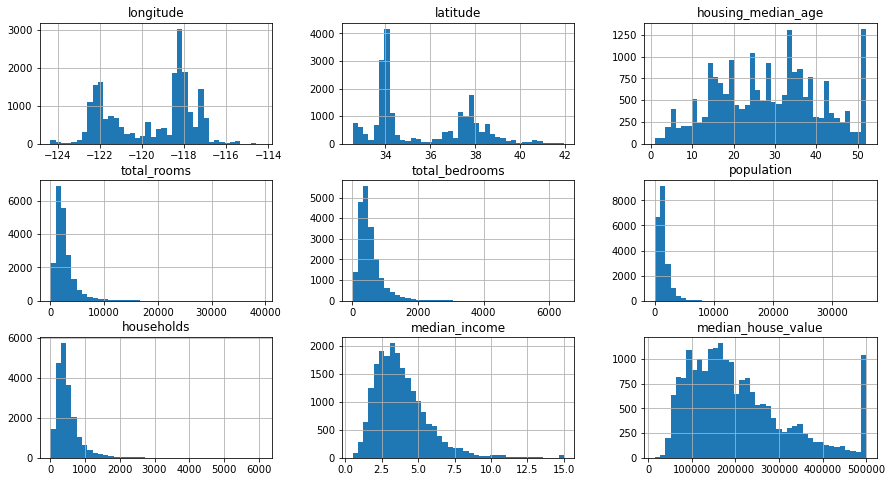

In [7]:
housing_df.hist(figsize=(15,8), bins=40) 
# figsize = how stretch the figure will be
# bins = how smooth the distribution looks like, divide data into smaller bins

### Creating a Test Set

- Here we have randomly selected the test set which is not the ideal way because it might introduce the sampling bias. Test set should be the representative of all the dataset to produce reliable & accurate results.
- Assuming 'median_income' feature is very important in predicting 'median_house_value' so the test set should be representative of this feature.
- Looking at 'median_income', it appears to be divided mostly from 1.5 to 6. Let's create new feature 'income_cat'to represent categories for this continous variable. Categories shouldn't be too large or small
- pd.cut() function provides the way to create these categories
- train_test_split() function provides an argument stratify=feature_name which is used to create test set with stratified strategy

In [8]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],
                                 bins=[0.,1.5,3.,4.5,6., np.inf],
                                 labels=[1,2,3,4,5]) # np.inf required as bins should > labels

Text(0, 0.5, 'Number of districts')

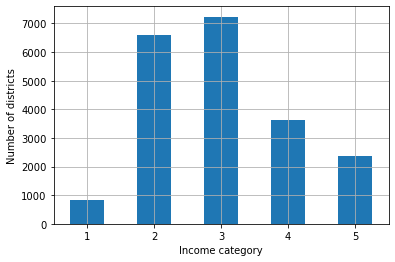

In [9]:
housing_df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True) # rot: 
plt.xlabel("Income category")
plt.ylabel("Number of districts")

In [10]:
# unstratified data
unstrat_train_set, unstrat_test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

In [11]:
# stratified sampling
strat_train_set, strat_test_set = train_test_split(housing_df, test_size=0.2, random_state=42, stratify=housing_df["income_cat"])

In [12]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set) # total strat test set = 4128


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [13]:
# we won't use the income_cat feature again & also don't want it to influence our predictions, so we will remove it
for feat_set in (strat_train_set, strat_test_set):
    feat_set.drop("income_cat", axis=1, inplace=True)

C:\Users\akshaythakare\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 3. Explore & Visualise the Data to Gain Insights

In [14]:
# Lets' copy the original data to analyse/manipulate

housing = strat_train_set.copy()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17950,-118.15,34.16,52.0,1925.0,597.0,2258.0,594.0,1.6921,162500.0,<1H OCEAN
19445,-118.48,34.05,48.0,3623.0,528.0,1282.0,516.0,9.5221,500001.0,<1H OCEAN
15413,-118.25,33.93,42.0,657.0,147.0,526.0,132.0,2.5000,110200.0,<1H OCEAN
4371,-120.54,38.07,37.0,736.0,148.0,339.0,140.0,2.2875,79900.0,INLAND
2921,-117.32,33.17,18.0,2143.0,299.0,828.0,283.0,4.2383,239000.0,NEAR OCEAN


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

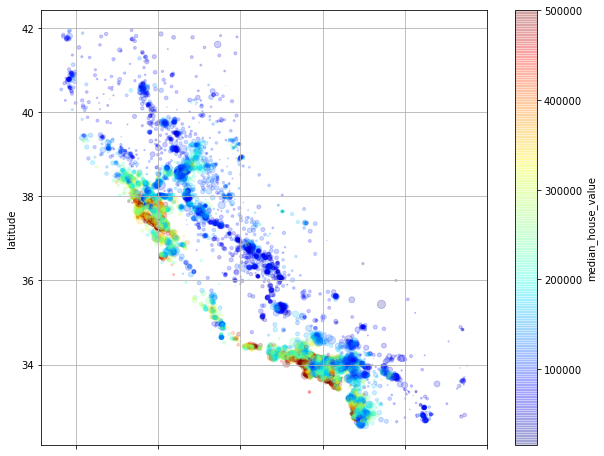

In [15]:
# As we are dealing with geographical data so it make sense to plot the scatterplot

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2,
            grid=True, s=housing["population"]/100, 
             cmap="jet", c="median_house_value",
            figsize=(10,8)) # alpha represents high density areas

### Correlations of attributes

In [16]:
corr_matrix = housing.corr() # corr method uses Pearson' coefficient

In [17]:
corr_matrix["median_house_value"].sort_values()

latitude             -0.139603
longitude            -0.050813
population           -0.020134
total_bedrooms        0.054707
households            0.071490
housing_median_age    0.102016
total_rooms           0.137549
median_income         0.688390
median_house_value    1.000000
Name: median_house_value, dtype: float64

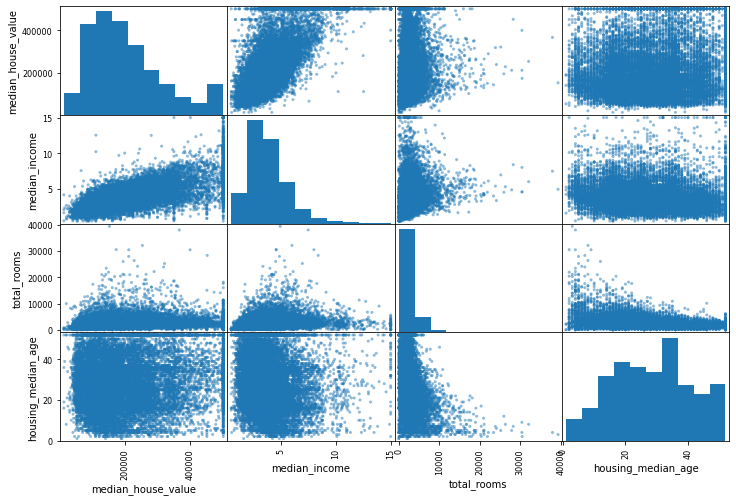

In [18]:
# Another way to look the correlations between numerical attributes is scatter plots
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()
# only promising attribute to predict median_house_value would be median_income

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

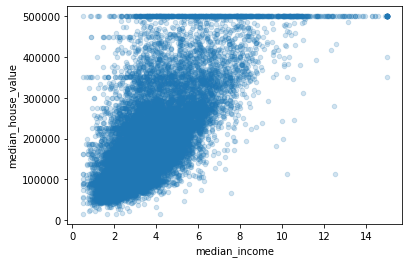

In [19]:
# lets zoom in with median_income
housing.plot(kind="scatter",x="median_income", y="median_house_value",alpha=0.2)